In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 1
price = 106
iteration = 6


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Medium Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

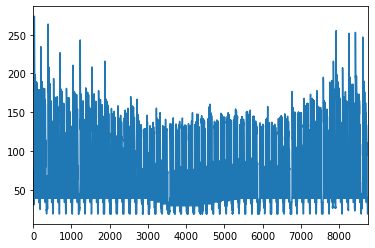

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 29,169.86
273.7716055773879


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 1,661 m²
Roof area is up 33 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 40.59007430076599 sec


0.0


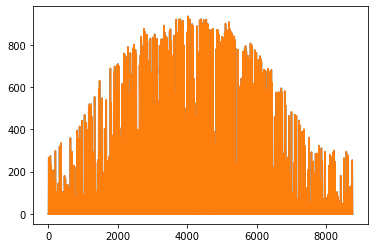

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 110s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 71422.1


ERROR:ga_logger:total demand cost: 29169.85


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 695,621 kWh
At a cost of $ 0.0606 /kWh
Total Cost of the system: $ 71,422 per year


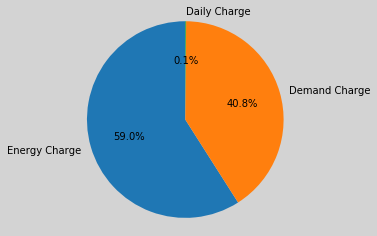

Total roof area of the  building: 1,661 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

695621.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    29169.85
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         52160.4
Aug         56563.1
Dec         69736.5
Feb         57584.1
Jan         71584.2
Jul         51790.7
Jun         50497.1
Mar         62938.7
May         50835.5
Nov         63932.9
Oct         57272.7
Sep         50724.4
monthly_import    695620.3
dtype: float64
695621.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

1

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (95, 140, 195, 56, 6, 16, 0.7499999999999998, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69276.3


ERROR:ga_logger:total demand cost: 28098.579999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,851 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,276 per year


Total roof area of the  building: 1,661 m²
Total roof area used 694 m²
Percentage: 41.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 260, 265, 31, 21, 16, 0.6499999999999999, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69475.7


ERROR:ga_logger:total demand cost: 28207.719999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 590,302 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,476 per year


Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (120, 265, 225, 16, 21, 11, 0.25, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 16.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.5842924118042 sec


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [284.046, 0.0, 340.954]


ERROR:ga_logger:Cost: 69192.5


ERROR:ga_logger:total demand cost: 28064.88


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,829 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,192 per year


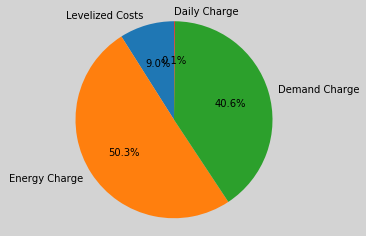

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (265, 125, 230, 51, 36, 16, 0.49999999999999994, 0.39999999999999997, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 349.96, 275.04]


ERROR:ga_logger:Cost: 69223.2


ERROR:ga_logger:total demand cost: 28095.649999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,089 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,223 per year


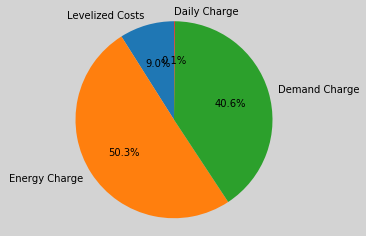

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 200, 130, 21, 21, 36, 0.49999999999999994, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [419.636, 205.364, 0.0]


ERROR:ga_logger:Cost: 68955.3


ERROR:ga_logger:total demand cost: 28074.059999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,389 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 68,955 per year


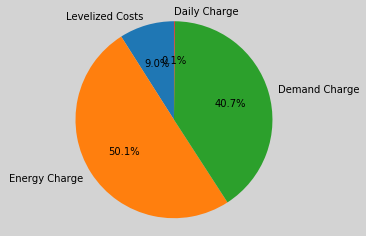

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 190, 235, 31, 6, 6, 0.5999999999999999, 0.8499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68784.0


ERROR:ga_logger:total demand cost: 28116.97


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,601 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,784 per year


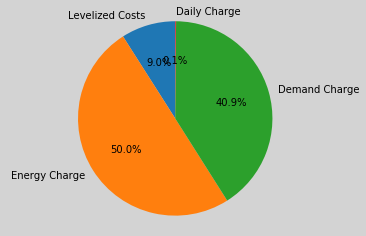

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (190, 225, 110, 46, 21, 26, 0.5499999999999999, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69001.1


ERROR:ga_logger:total demand cost: 28160.969999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,018 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 69,001 per year


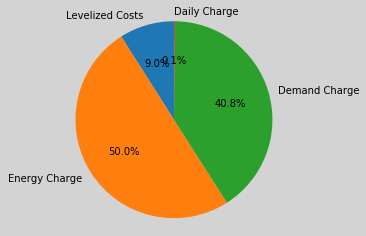

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 140, 180, 11, 21, 31, 0.35, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 316.954, 308.046]


ERROR:ga_logger:Cost: 68728.9


ERROR:ga_logger:total demand cost: 28087.899999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,650 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,729 per year


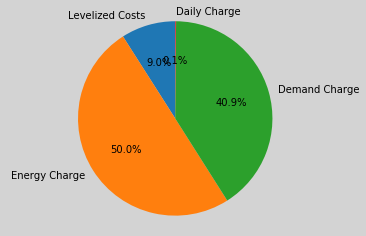

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 100, 115, 31, 46, 31, 0.7499999999999998, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69147.8


ERROR:ga_logger:total demand cost: 28135.739999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,538 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,148 per year


Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 140, 260, 11, 6, 56, 0.8499999999999999, 0.8999999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69397.2


ERROR:ga_logger:total demand cost: 28064.979999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,953 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,397 per year


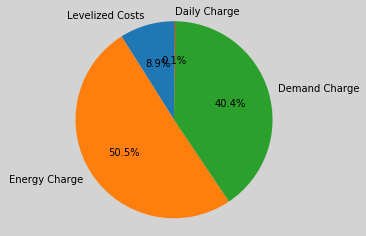

Total roof area of the  building: 1,661 m²
Total roof area used 694 m²
Percentage: 41.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 160, 105, 21, 6, 56, 0.6499999999999999, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68831.0


ERROR:ga_logger:total demand cost: 28089.54


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,732 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,831 per year


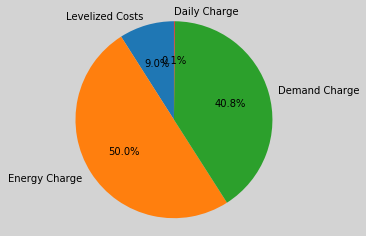

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 130, 215, 31, 46, 6, 0.5999999999999999, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68994.4


ERROR:ga_logger:total demand cost: 28119.659999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,403 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,994 per year


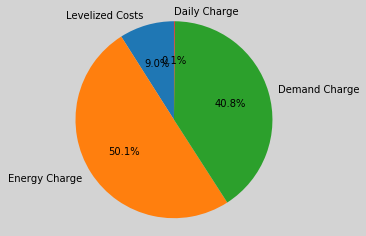

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 255, 100, 56, 41, 41, 0.49999999999999994, 0.3, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 481.987, 27.0531]


ERROR:ga_logger:Cost: 70163.0


ERROR:ga_logger:total demand cost: 28192.23


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 614,883 kWh
At a cost of $ 0.0599 /kWh
Total Cost of the system: $ 70,163 per year


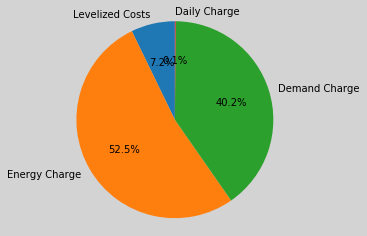

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 175, 255, 11, 21, 31, 0.25, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68698.6


ERROR:ga_logger:total demand cost: 28079.889999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,213 kWh
At a cost of $ 0.0588 /kWh
Total Cost of the system: $ 68,699 per year


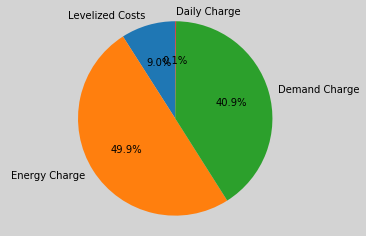

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (210, 205, 180, 11, 36, 41, 0.39999999999999997, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68718.5


ERROR:ga_logger:total demand cost: 28133.75


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,533 kWh
At a cost of $ 0.0590 /kWh
Total Cost of the system: $ 68,718 per year


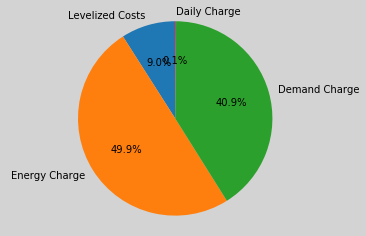

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (210, 240, 190, 56, 31, 51, 0.7499999999999998, 0.5999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69355.7


ERROR:ga_logger:total demand cost: 28192.29


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,254 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,356 per year


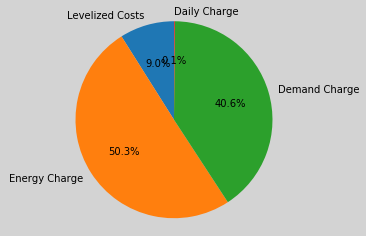

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 255, 120, 36, 41, 41, 0.5999999999999999, 0.35, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69017.4


ERROR:ga_logger:total demand cost: 28136.55


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,097 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,017 per year


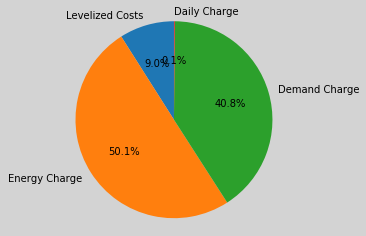

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (200, 180, 265, 36, 36, 21, 0.8499999999999999, 0.5999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 21.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.729814529418945 sec


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68808.2


ERROR:ga_logger:total demand cost: 28132.79


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,921 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,808 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 135, 240, 21, 51, 21, 0.5999999999999999, 0.8999999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [17.1447, 0.0, 607.855]


ERROR:ga_logger:Cost: 69631.2


ERROR:ga_logger:total demand cost: 28094.279999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 593,365 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,631 per year


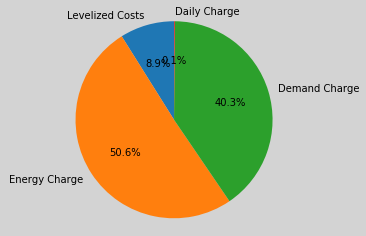

Total roof area of the  building: 1,661 m²
Total roof area used 839 m²
Percentage: 50.5%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 95, 195, 16, 36, 46, 0.7, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68937.1


ERROR:ga_logger:total demand cost: 28162.25


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,461 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,937 per year


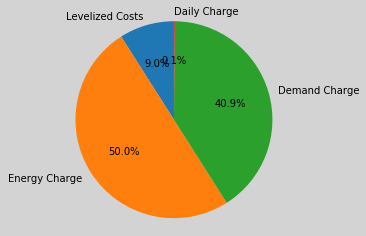

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 260, 245, 41, 56, 31, 0.7, 0.49999999999999994, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69622.0


ERROR:ga_logger:total demand cost: 28223.219999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 591,973 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,622 per year


Total roof area of the  building: 1,661 m²
Total roof area used 893 m²
Percentage: 53.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 110, 255, 26, 56, 1, 0.25, 0.5999999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [152.91, 0.0, 472.09]


ERROR:ga_logger:Cost: 69308.8


ERROR:ga_logger:total demand cost: 28060.979999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,378 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,309 per year


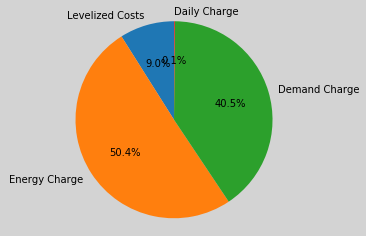

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 260, 215, 6, 1, 26, 0.5999999999999999, 0.44999999999999996, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69206.9


ERROR:ga_logger:total demand cost: 28056.62


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,379 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,207 per year


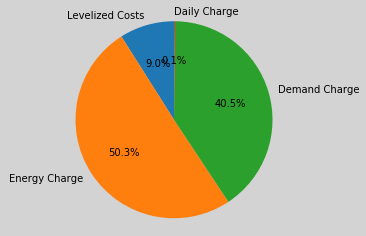

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 160, 225, 1, 16, 36, 0.3, 0.6499999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68934.1


ERROR:ga_logger:total demand cost: 28076.48


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,202 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,934 per year


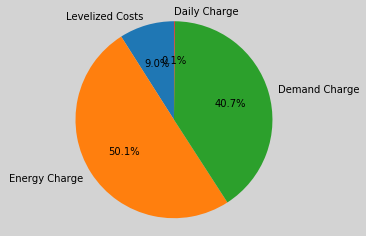

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 225, 255, 56, 51, 11, 0.44999999999999996, 0.7, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69560.4


ERROR:ga_logger:total demand cost: 28064.219999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 591,892 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,560 per year


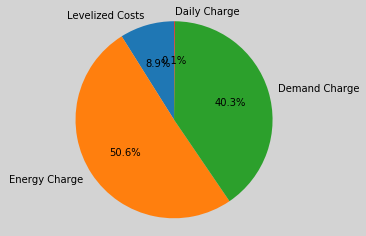

Total roof area of the  building: 1,661 m²
Total roof area used 893 m²
Percentage: 53.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (190, 225, 100, 16, 26, 16, 0.8499999999999999, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [195.935, 429.065, 0.0]


ERROR:ga_logger:Cost: 69028.2


ERROR:ga_logger:total demand cost: 28082.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,562 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,028 per year


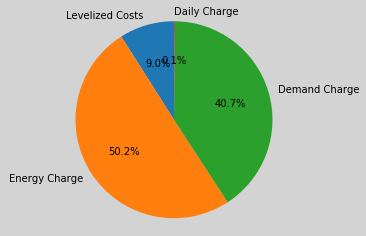

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (185, 245, 90, 11, 41, 41, 0.2, 0.2, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 13.058032274246216 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in  13s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [332.146, 0.0, 0.0]


ERROR:ga_logger:Cost: 69809.9


ERROR:ga_logger:total demand cost: 28277.179999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 631,958 kWh
At a cost of $ 0.0603 /kWh
Total Cost of the system: $ 69,810 per year


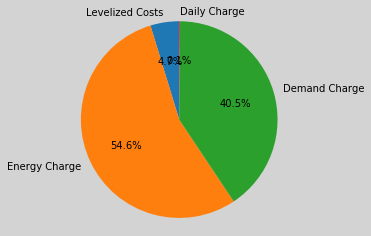

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 235, 220, 6, 56, 1, 0.25, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 1.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.2663254737854 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [310.273, 0.0, 314.727]


ERROR:ga_logger:Cost: 69355.0


ERROR:ga_logger:total demand cost: 28054.879999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,251 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,355 per year


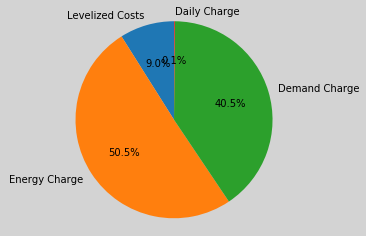

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 100, 165, 46, 26, 26, 0.49999999999999994, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 46.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.572009325027466 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69129.7


ERROR:ga_logger:total demand cost: 28161.13


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,289 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,130 per year


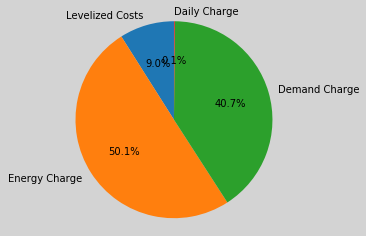

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 230, 100, 51, 1, 16, 0.49999999999999994, 0.49999999999999994, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 1.0
                                           and a gcr of 0.500


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.367022037506104 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69139.2


ERROR:ga_logger:total demand cost: 28176.44


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 596,718 kWh
At a cost of $ 0.0581 /kWh
Total Cost of the system: $ 69,139 per year


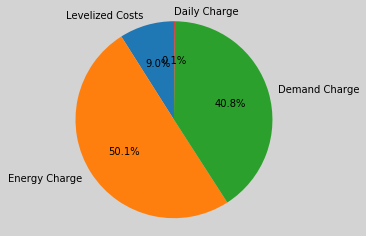

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 150, 110, 6, 21, 11, 0.7999999999999998, 0.39999999999999997, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68778.1


ERROR:ga_logger:total demand cost: 28077.95


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,965 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,778 per year


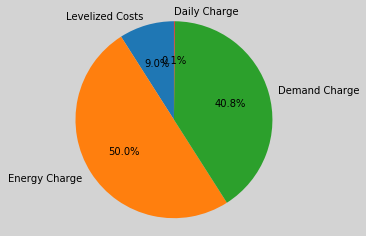

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 230, 180, 11, 51, 36, 0.2, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68966.7


ERROR:ga_logger:total demand cost: 28144.999999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,413 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,967 per year


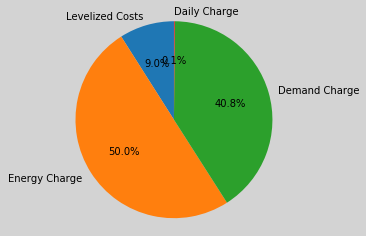

Total roof area of the  building: 1,661 m²
Total roof area used 893 m²
Percentage: 53.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (185, 265, 160, 16, 11, 36, 0.6499999999999999, 0.25, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68864.9


ERROR:ga_logger:total demand cost: 28074.75


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 582,026 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,865 per year


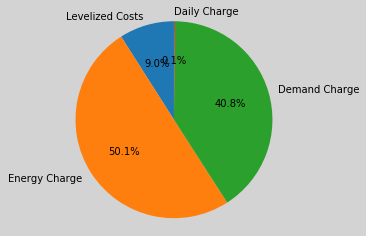

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 190, 120, 56, 16, 56, 0.5999999999999999, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.746599197387695 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68923.2


ERROR:ga_logger:total demand cost: 28077.369999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,396 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,923 per year


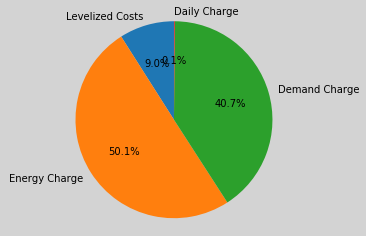

Total roof area of the  building: 1,661 m²
Total roof area used 893 m²
Percentage: 53.8%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (135, 125, 180, 31, 56, 36, 0.44999999999999996, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68808.2


ERROR:ga_logger:total demand cost: 28132.79


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,369 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,808 per year


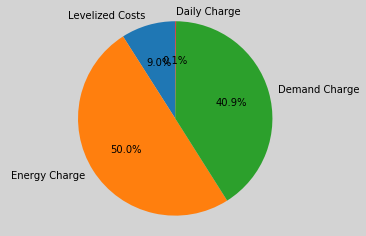

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 210, 235, 6, 31, 16, 0.35, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 6.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.727158546447754 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.7839937210083 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.498859405517578 sec


ERROR:ga_logger:Generated the panel irradiance in  30s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [15.2741, 609.726, 0.0]


ERROR:ga_logger:Cost: 68807.0


ERROR:ga_logger:total demand cost: 28095.75


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,783 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,807 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,568 m²
Percentage: 94.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 170, 230, 36, 6, 56, 0.7999999999999998, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69230.2


ERROR:ga_logger:total demand cost: 28058.649999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,596 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,230 per year


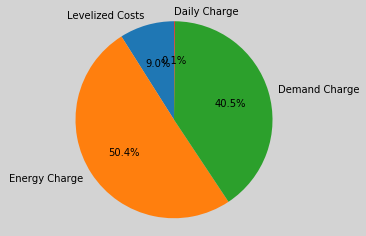

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (95, 110, 175, 6, 56, 26, 0.25, 0.35, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68738.1


ERROR:ga_logger:total demand cost: 28100.18


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,356 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,738 per year


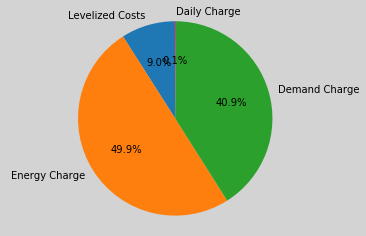

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (140, 210, 215, 1, 21, 1, 0.5999999999999999, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 1.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69145.0


ERROR:ga_logger:total demand cost: 28095.379999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,643 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,145 per year


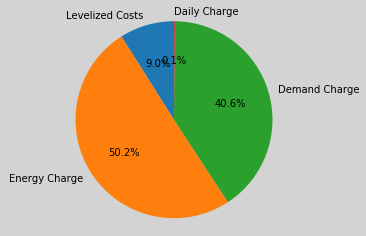

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 220, 250, 56, 36, 11, 0.25, 0.2, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 581.255]


ERROR:ga_logger:Cost: 69525.7


ERROR:ga_logger:total demand cost: 28090.18


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 596,377 kWh
At a cost of $ 0.0596 /kWh
Total Cost of the system: $ 69,526 per year


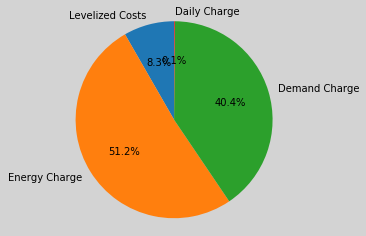

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 155, 245, 46, 16, 31, 0.3, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68897.9


ERROR:ga_logger:total demand cost: 28072.409999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,615 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 68,898 per year


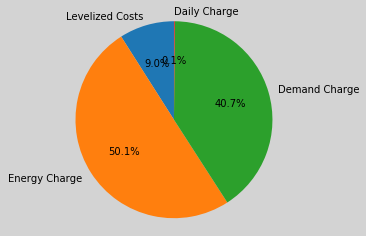

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 90, 150, 11, 51, 56, 0.2, 0.49999999999999994, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [97.8623, 0.0, 527.138]


ERROR:ga_logger:Cost: 69513.7


ERROR:ga_logger:total demand cost: 28172.25


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,673 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,514 per year


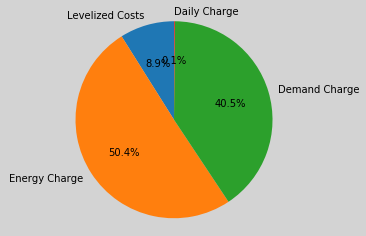

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 195, 105, 16, 21, 1, 0.2, 0.8999999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [248.473, 376.527, 0.0]


ERROR:ga_logger:Cost: 69131.1


ERROR:ga_logger:total demand cost: 28096.789999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,902 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,131 per year


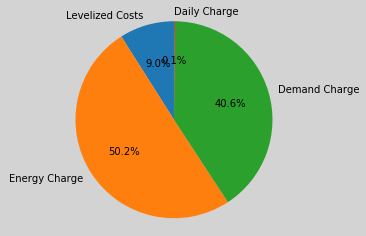

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 215, 200, 6, 6, 36, 0.8999999999999999, 0.7499999999999998, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 36.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69304.0


ERROR:ga_logger:total demand cost: 28057.679999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,093 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,304 per year


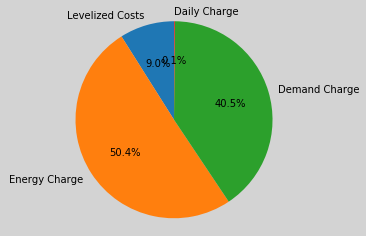

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (145, 200, 255, 31, 41, 51, 0.5999999999999999, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.611127376556396 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [34.9346, 590.065, 0.0]


ERROR:ga_logger:Cost: 68812.5


ERROR:ga_logger:total demand cost: 28125.69


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,723 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,812 per year


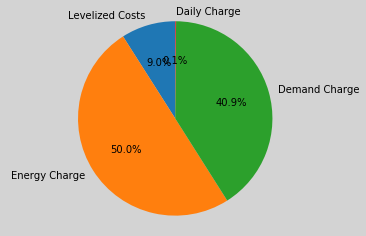

Total roof area of the  building: 1,661 m²
Total roof area used 1,533 m²
Percentage: 92.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 150, 110, 21, 6, 1, 0.7499999999999998, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69236.2


ERROR:ga_logger:total demand cost: 28057.089999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,200 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,236 per year


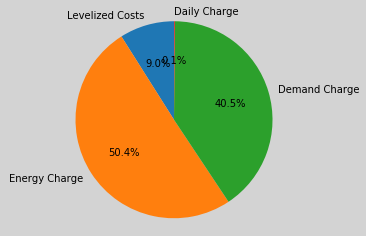

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (130, 90, 235, 41, 56, 36, 0.44999999999999996, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 56.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.21185564994812 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.831596374511719 sec


ERROR:ga_logger:Generated the panel irradiance in  20s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69377.9


ERROR:ga_logger:total demand cost: 28142.089999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,754 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,378 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 170, 225, 31, 46, 26, 0.49999999999999994, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68694.7


ERROR:ga_logger:total demand cost: 28108.44


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 578,980 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,695 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 135, 220, 11, 21, 26, 0.7499999999999998, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 15.15004014968872 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in  15s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 14.6357, 610.364]


ERROR:ga_logger:Cost: 68970.7


ERROR:ga_logger:total demand cost: 28085.71


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,605 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,971 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,383 m²
Percentage: 83.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (195, 160, 220, 11, 31, 41, 0.7, 0.3, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [221.867, 403.133, 0.0]


ERROR:ga_logger:Cost: 68740.2


ERROR:ga_logger:total demand cost: 28084.72


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,879 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,740 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 115, 125, 16, 11, 56, 0.3, 0.3, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [498.219, 0.0, 0.0]


ERROR:ga_logger:Cost: 69332.4


ERROR:ga_logger:total demand cost: 28156.42


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 638,654 kWh
At a cost of $ 0.0566 /kWh
Total Cost of the system: $ 69,332 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (165, 130, 130, 56, 26, 36, 0.8499999999999999, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69322.3


ERROR:ga_logger:total demand cost: 28129.719999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,376 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,322 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 115, 190, 56, 11, 36, 0.39999999999999997, 0.2, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68605.7


ERROR:ga_logger:total demand cost: 28111.94


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 578,622 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,606 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (105, 130, 165, 41, 16, 46, 0.2, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 46.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 553.417, 71.5827]


ERROR:ga_logger:Cost: 69134.4


ERROR:ga_logger:total demand cost: 28085.21


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,915 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,134 per year


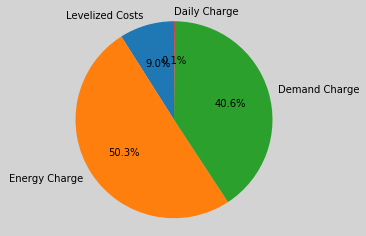

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 110, 130, 36, 26, 16, 0.8999999999999999, 0.35, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69205.4


ERROR:ga_logger:total demand cost: 28078.59


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,818 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,205 per year


Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 95, 230, 36, 1, 11, 0.7, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 1.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.338140964508057 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69328.5


ERROR:ga_logger:total demand cost: 28066.469999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,088 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,328 per year


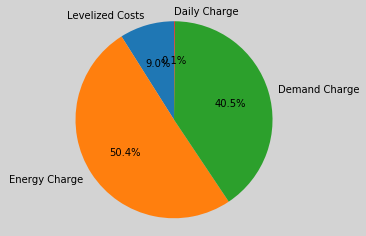

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (160, 105, 150, 41, 41, 31, 0.5499999999999999, 0.3, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68985.2


ERROR:ga_logger:total demand cost: 28147.989999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,465 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,985 per year


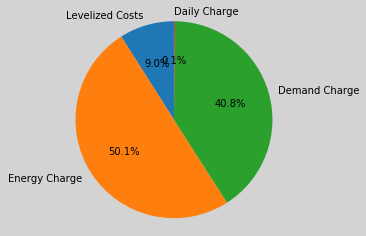

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 90, 165, 31, 41, 21, 0.39999999999999997, 0.8499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.400


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.353423833847046 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68727.8


ERROR:ga_logger:total demand cost: 28080.809999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,100 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,728 per year


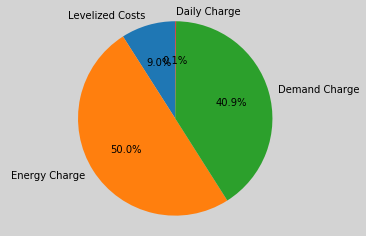

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 250, 245, 46, 21, 16, 0.8499999999999999, 0.35, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 470.212, 154.788]


ERROR:ga_logger:Cost: 69476.1


ERROR:ga_logger:total demand cost: 28075.429999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 591,855 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,476 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,565 m²
Percentage: 94.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (265, 225, 135, 16, 46, 51, 0.3, 0.8499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [403.133, 0.0, 221.867]


ERROR:ga_logger:Cost: 69854.1


ERROR:ga_logger:total demand cost: 28114.369999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 594,586 kWh
At a cost of $ 0.0596 /kWh
Total Cost of the system: $ 69,854 per year


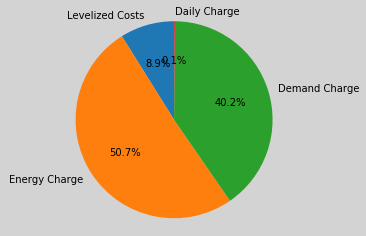

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (230, 140, 115, 31, 26, 6, 0.8499999999999999, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 371.437, 253.563]


ERROR:ga_logger:Cost: 69037.6


ERROR:ga_logger:total demand cost: 28074.73


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,765 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,038 per year


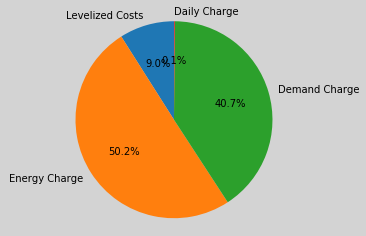

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (245, 260, 210, 21, 26, 6, 0.2, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 21.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.860683441162109 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69284.5


ERROR:ga_logger:total demand cost: 28057.76


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,170 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,284 per year


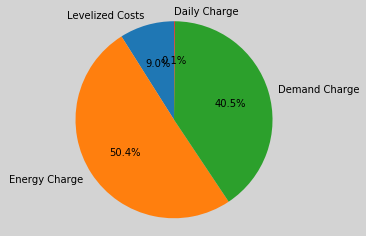

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (185, 200, 200, 11, 16, 26, 0.7, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68702.8


ERROR:ga_logger:total demand cost: 28087.069999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,650 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,703 per year


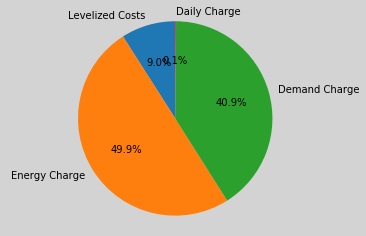

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 170, 250, 11, 11, 56, 0.7499999999999998, 0.5999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69000.0


ERROR:ga_logger:total demand cost: 28063.42


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,260 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,000 per year


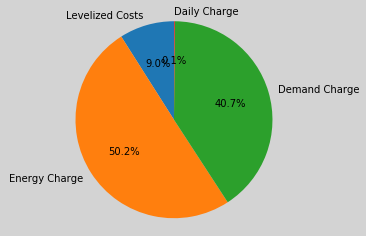

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 125, 210, 51, 51, 51, 0.7499999999999998, 0.8999999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69592.3


ERROR:ga_logger:total demand cost: 28209.51


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 591,768 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,592 per year


Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (235, 95, 110, 6, 36, 51, 0.5999999999999999, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69384.3


ERROR:ga_logger:total demand cost: 28055.71


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,135 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,384 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (255, 170, 185, 36, 11, 56, 0.7499999999999998, 0.25, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 265.312, 359.688]


ERROR:ga_logger:Cost: 69226.6


ERROR:ga_logger:total demand cost: 28142.87


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,694 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,227 per year


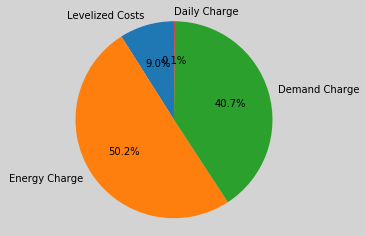

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (235, 175, 215, 51, 1, 6, 0.8499999999999999, 0.6499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 235.451, 389.549]


ERROR:ga_logger:Cost: 69357.2


ERROR:ga_logger:total demand cost: 28054.429999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,603 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,357 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 205, 250, 1, 1, 11, 0.25, 0.2, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [334.483, 0.0, 290.517]


ERROR:ga_logger:Cost: 69612.1


ERROR:ga_logger:total demand cost: 28065.739999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 592,760 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,612 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 155, 205, 21, 11, 31, 0.6499999999999999, 0.35, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68725.5


ERROR:ga_logger:total demand cost: 28096.260000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,974 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,726 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (260, 255, 230, 16, 36, 11, 0.7499999999999998, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69328.5


ERROR:ga_logger:total demand cost: 28066.469999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,044 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,328 per year


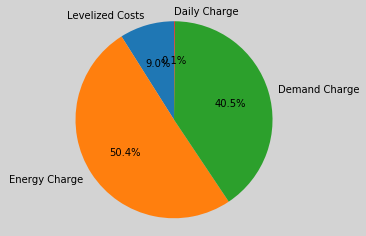

Total roof area of the  building: 1,661 m²
Total roof area used 833 m²
Percentage: 50.2%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (110, 205, 225, 31, 6, 41, 0.6499999999999999, 0.8499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69305.6


ERROR:ga_logger:total demand cost: 28060.589999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,149 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,306 per year


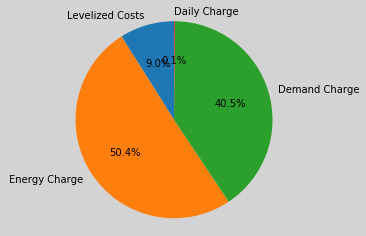

Total roof area of the  building: 1,661 m²
Total roof area used 735 m²
Percentage: 44.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (190, 140, 175, 1, 21, 36, 0.2, 0.35, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 550.634, 74.3665]


ERROR:ga_logger:Cost: 68914.6


ERROR:ga_logger:total demand cost: 28087.79


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,981 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,915 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (140, 260, 115, 41, 1, 31, 0.49999999999999994, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 41.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69240.9


ERROR:ga_logger:total demand cost: 28145.76


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 600,820 kWh
At a cost of $ 0.0579 /kWh
Total Cost of the system: $ 69,241 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (195, 260, 235, 21, 1, 1, 0.25, 0.44999999999999996, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [319.81, 0.0, 305.19]


ERROR:ga_logger:Cost: 69083.7


ERROR:ga_logger:total demand cost: 28061.91


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,095 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,084 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (205, 235, 205, 11, 16, 21, 0.5999999999999999, 0.7, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.014535903930664 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 21.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [253.563, 0.0, 371.437]


ERROR:ga_logger:Cost: 68884.8


ERROR:ga_logger:total demand cost: 28066.72


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,743 kWh
At a cost of $ 0.0589 /kWh
Total Cost of the system: $ 68,885 per year


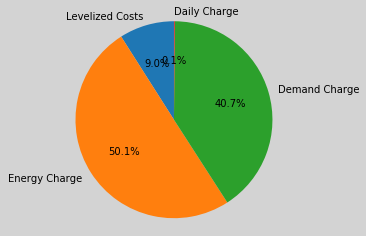

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (240, 265, 175, 6, 16, 1, 0.35, 0.5499999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [537.51, 0.0, 87.49]


ERROR:ga_logger:Cost: 69416.5


ERROR:ga_logger:total demand cost: 28054.44


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,769 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,416 per year


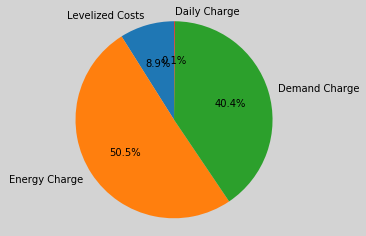

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 225, 255, 36, 16, 41, 0.39999999999999997, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [507.126, 117.874, 0.0]


ERROR:ga_logger:Cost: 69246.7


ERROR:ga_logger:total demand cost: 28110.219999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 591,963 kWh
At a cost of $ 0.0588 /kWh
Total Cost of the system: $ 69,247 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (195, 90, 215, 6, 1, 41, 0.3, 0.6499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [389.549, 235.451, 0.0]


ERROR:ga_logger:Cost: 69338.4


ERROR:ga_logger:total demand cost: 28054.78


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 594,948 kWh
At a cost of $ 0.0588 /kWh
Total Cost of the system: $ 69,338 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (170, 225, 215, 56, 46, 26, 0.2, 0.44999999999999996, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68928.2


ERROR:ga_logger:total demand cost: 28089.11


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,499 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,928 per year


ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (230, 100, 185, 31, 11, 1, 0.7, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69486.0


ERROR:ga_logger:total demand cost: 28054.219999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 601,931 kWh
At a cost of $ 0.0584 /kWh
Total Cost of the system: $ 69,486 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 115, 195, 11, 46, 36, 0.8499999999999999, 0.5999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68880.7


ERROR:ga_logger:total demand cost: 28130.82


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,033 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,881 per year


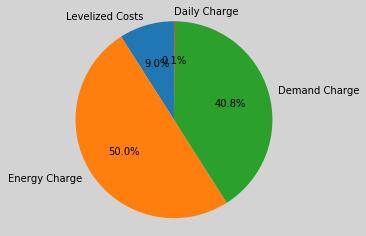

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 125, 95, 46, 11, 26, 0.7999999999999998, 0.2, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 215.004, 409.996]


ERROR:ga_logger:Cost: 69872.9


ERROR:ga_logger:total demand cost: 28097.97


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 619,513 kWh
At a cost of $ 0.0573 /kWh
Total Cost of the system: $ 69,873 per year


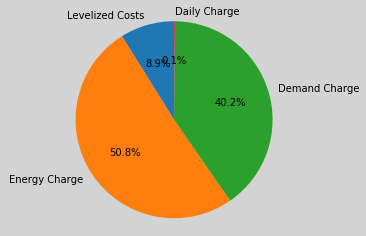

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (100, 170, 165, 46, 1, 21, 0.7, 0.2, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.700


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.954902410507202 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68677.5


ERROR:ga_logger:total demand cost: 28076.55


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,472 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,678 per year


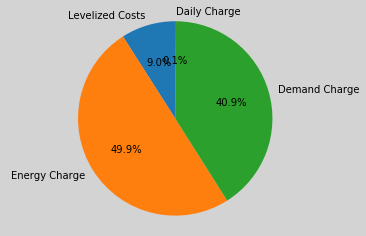

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 250, 95, 51, 6, 46, 0.6499999999999999, 0.2, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 332.146, 0.0]


ERROR:ga_logger:Cost: 70079.1


ERROR:ga_logger:total demand cost: 28275.269999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 636,689 kWh
At a cost of $ 0.0603 /kWh
Total Cost of the system: $ 70,079 per year


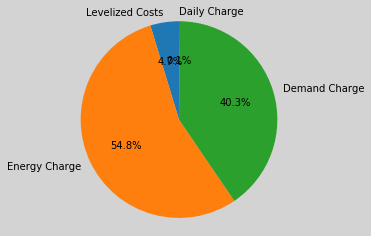

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 185, 235, 1, 41, 16, 0.6499999999999999, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69256.7


ERROR:ga_logger:total demand cost: 28177.579999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,546 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,257 per year


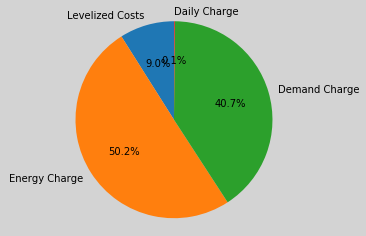

Total roof area of the  building: 1,661 m²
Total roof area used 781 m²
Percentage: 47.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (90, 230, 220, 1, 21, 36, 0.7499999999999998, 0.25, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [314.727, 0.0, 310.273]


ERROR:ga_logger:Cost: 69233.3


ERROR:ga_logger:total demand cost: 28076.19


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,393 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 69,233 per year


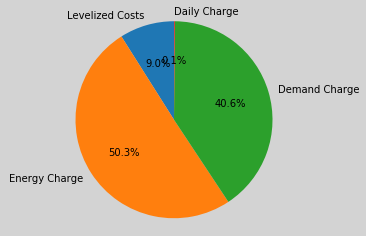

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 170, 265, 51, 51, 26, 0.5999999999999999, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 51.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 51.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.011643409729004 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 581.255, 0.0]


ERROR:ga_logger:Cost: 69064.7


ERROR:ga_logger:total demand cost: 28184.599999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,551 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,065 per year


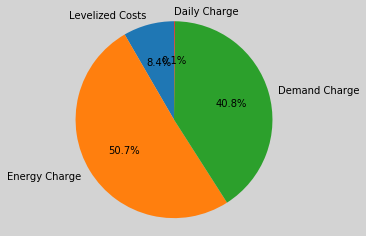

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (130, 140, 265, 11, 26, 31, 0.5499999999999999, 0.8499999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69186.8


ERROR:ga_logger:total demand cost: 28064.299999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,301 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,187 per year


Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (220, 180, 200, 11, 46, 16, 0.7999999999999998, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68890.2


ERROR:ga_logger:total demand cost: 28069.429999999997


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 582,087 kWh
At a cost of $ 0.0593 /kWh
Total Cost of the system: $ 68,890 per year


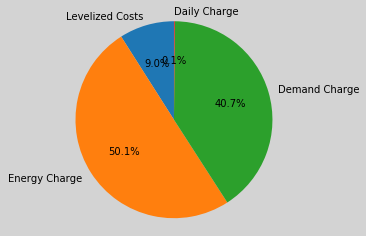

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (115, 105, 195, 26, 31, 36, 0.7499999999999998, 0.8999999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68962.6


ERROR:ga_logger:total demand cost: 28136.71


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 584,056 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,963 per year


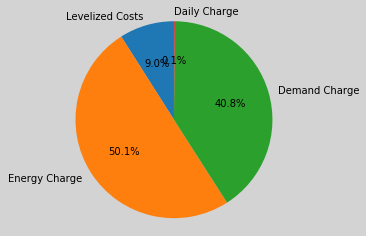

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (125, 205, 225, 41, 56, 11, 0.7999999999999998, 0.3, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69202.4


ERROR:ga_logger:total demand cost: 28060.35


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 586,795 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,202 per year


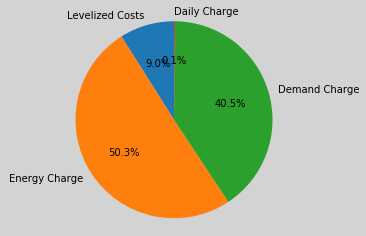

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (250, 260, 240, 56, 21, 51, 0.5499999999999999, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.758364677429199 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69809.5


ERROR:ga_logger:total demand cost: 28123.28


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 594,986 kWh
At a cost of $ 0.0595 /kWh
Total Cost of the system: $ 69,810 per year


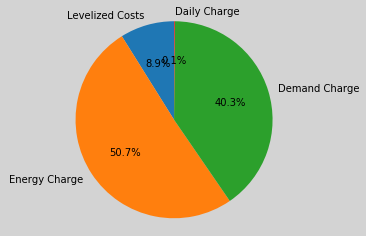

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (155, 260, 215, 11, 36, 1, 0.8499999999999999, 0.5499999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 69236.9


ERROR:ga_logger:total demand cost: 28076.0


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,222 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,237 per year


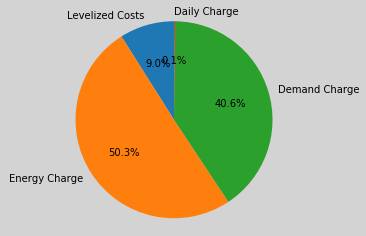

Total roof area of the  building: 1,661 m²
Total roof area used 735 m²
Percentage: 44.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (225, 145, 225, 31, 6, 6, 0.5999999999999999, 0.49999999999999994, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 69247.7


ERROR:ga_logger:total demand cost: 28056.93


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 589,426 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,248 per year


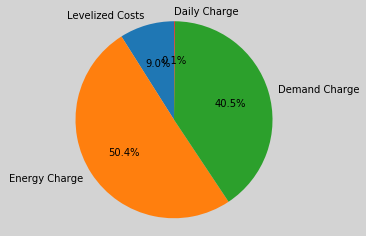

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (215, 230, 130, 11, 26, 1, 0.7999999999999998, 0.25, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [305.19, 319.81, 0.0]


ERROR:ga_logger:Cost: 69150.7


ERROR:ga_logger:total demand cost: 28072.76


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 587,509 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 69,151 per year


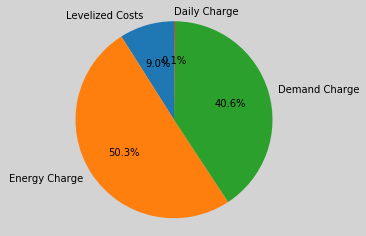

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (150, 170, 190, 41, 1, 36, 0.8999999999999999, 0.6499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68648.3


ERROR:ga_logger:total demand cost: 28116.229999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,567 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,648 per year


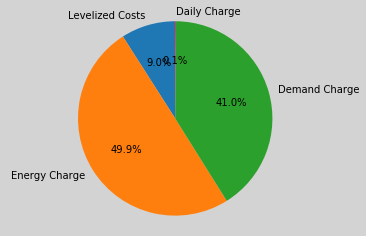

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (220, 95, 200, 46, 56, 11, 0.35, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.66289210319519 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 69149.5


ERROR:ga_logger:total demand cost: 28070.07


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,729 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,150 per year


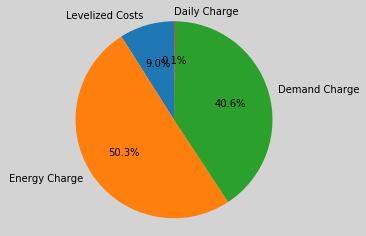

Total roof area of the  building: 1,661 m²
Total roof area used 781 m²
Percentage: 47.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (195, 135, 265, 51, 21, 36, 0.6499999999999999, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [340.954, 284.046, 0.0]


ERROR:ga_logger:Cost: 69185.1


ERROR:ga_logger:total demand cost: 28138.329999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 585,264 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 69,185 per year


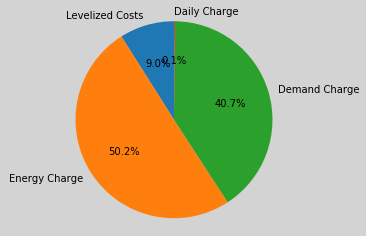

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: (180, 90, 155, 46, 1, 51, 0.39999999999999997, 0.25, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68793.3


ERROR:ga_logger:total demand cost: 28145.349999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,159 kWh
At a cost of $ 0.0584 /kWh
Total Cost of the system: $ 68,793 per year


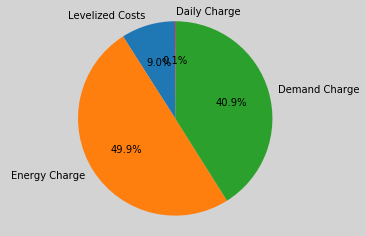

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
20
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0     180
azi1     115
azi2     190
tilt0     56
tilt1     11
tilt2     36
gcr0     0.4
gcr1     0.2
gcr2     0.4
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68605.7


ERROR:ga_logger:total demand cost: 28111.94


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 578,622 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,606 per year


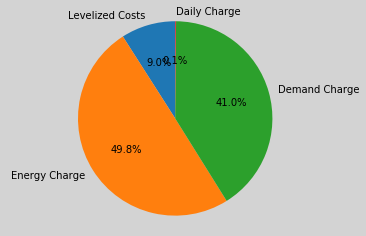

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
[[180, 115, 190, 56, 11, 36, 0.4, 0.2, 0.4, 68605.7, 625.0, 0.0, 0.0, 625.0, 1, 'red', {'Levelized Costs': 6207.723899999994, 'Energy Charge': 34188.471600000004, 'Demand Charge': 28111.94, 'Daily Charge': 97.5645}, 131454.05947387218, 578622.0, 1562.5]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      150
azi1      170
azi2      190
tilt0      41
tilt1       1
tilt2      36
gcr0      0.9
gcr1     0.65
gcr2     0.45
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68648.3


ERROR:ga_logger:total demand cost: 28116.229999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,567 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,648 per year


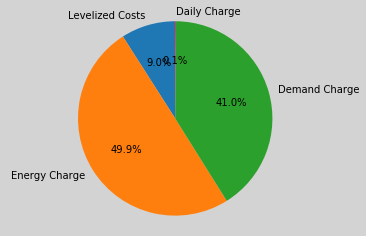

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
[[150, 170, 190, 41, 1, 36, 0.8999999999999999, 0.6499999999999999, 0.45, 68648.3, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.618399999999, 'Energy Charge': 34226.88710000001, 'Demand Charge': 28116.229999999996, 'Daily Charge': 97.5645}, 130820.74125944788, 579567.0, 1388.89]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      165
azi1      170
azi2      225
tilt0      31
tilt1      46
tilt2      26
gcr0      0.5
gcr1     0.55
gcr2      0.8
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 57s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68694.7


ERROR:ga_logger:total demand cost: 28108.44


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 578,980 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,695 per year


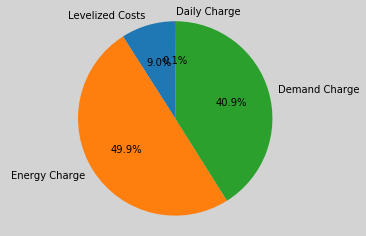

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
[[165, 170, 225, 31, 46, 26, 0.4999999999999999, 0.5499999999999999, 0.7999999999999998, 68694.7, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.621999999999, 'Energy Charge': 34281.0735, 'Demand Charge': 28108.44, 'Daily Charge': 97.5645}, 129926.33108879965, 578980.0, 1250.0]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0     100
azi1     170
azi2     165
tilt0     46
tilt1      1
tilt2     21
gcr0     0.7
gcr1     0.2
gcr2     0.4
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68677.5


ERROR:ga_logger:total demand cost: 28076.55


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,472 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,678 per year


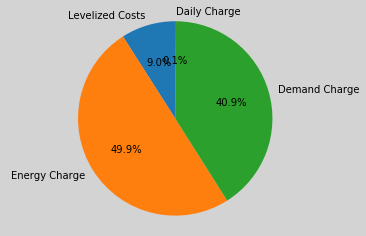

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
[[100, 170, 165, 46, 1, 21, 0.7, 0.2, 0.4, 68677.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.618310000002, 'Energy Charge': 34295.76719, 'Demand Charge': 28076.55, 'Daily Charge': 97.5645}, 129683.86821589978, 579472.0, 1562.5]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      195
azi1      160
azi2      220
tilt0      11
tilt1      31
tilt2      41
gcr0      0.7
gcr1      0.3
gcr2     0.45
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [221.867, 403.133, 0.0]


ERROR:ga_logger:Cost: 68740.2


ERROR:ga_logger:total demand cost: 28084.72


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 579,879 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,740 per year


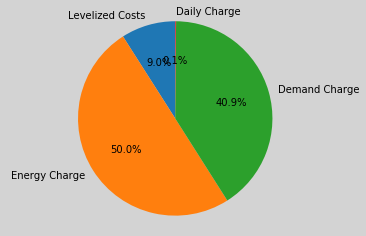

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
[[195, 160, 220, 11, 31, 41, 0.7, 0.3, 0.45, 68740.2, 625.0, 221.867, 403.133, 0.0, 1, 'blue', {'Levelized Costs': 6207.6083, 'Energy Charge': 34350.307199999996, 'Demand Charge': 28084.72, 'Daily Charge': 97.5645}, 128783.79615991285, 579879.0, 1660.73]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      260
azi1      175
azi2      255
tilt0      11
tilt1      21
tilt2      31
gcr0     0.25
gcr1      0.5
gcr2      0.5
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 31.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68698.6


ERROR:ga_logger:total demand cost: 28079.889999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 583,163 kWh
At a cost of $ 0.0588 /kWh
Total Cost of the system: $ 68,699 per year


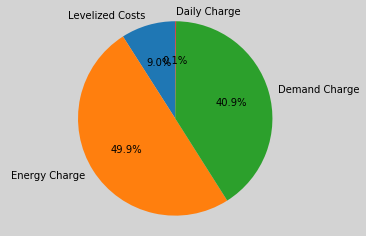

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
[[260, 175, 255, 11, 21, 31, 0.25, 0.4999999999999999, 0.4999999999999999, 68698.6, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.652780000008, 'Energy Charge': 34313.49272, 'Demand Charge': 28079.889999999996, 'Daily Charge': 97.5645}, 129391.32823431972, 583163.0, 1250.0]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      185
azi1      200
azi2      200
tilt0      11
tilt1      16
tilt2      26
gcr0      0.7
gcr1      0.4
gcr2     0.45
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68702.8


ERROR:ga_logger:total demand cost: 28087.069999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,650 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,703 per year


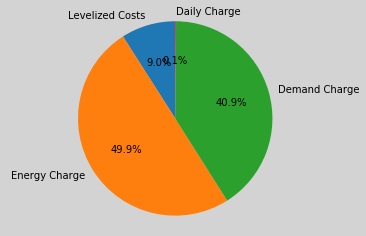

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
[[185, 200, 200, 11, 16, 26, 0.7, 0.4, 0.45, 68702.8, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.67600000001, 'Energy Charge': 34310.489499999996, 'Demand Charge': 28087.069999999996, 'Daily Charge': 97.5645}, 129441.07572250797, 580650.0, 1388.89]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      210
azi1      205
azi2      180
tilt0      11
tilt1      36
tilt2      41
gcr0      0.4
gcr1     0.65
gcr2     0.45
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68718.5


ERROR:ga_logger:total demand cost: 28133.75


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,533 kWh
At a cost of $ 0.0590 /kWh
Total Cost of the system: $ 68,718 per year


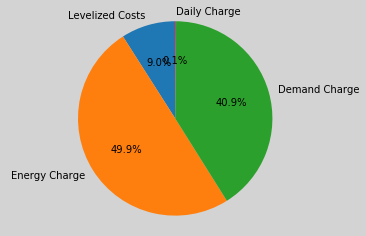

Total roof area of the  building: 1,661 m²
Total roof area used 1,389 m²
Percentage: 83.6%
[[210, 205, 180, 11, 36, 41, 0.4, 0.6499999999999999, 0.45, 68718.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.685400000002, 'Energy Charge': 34279.5001, 'Demand Charge': 28133.75, 'Daily Charge': 97.5645}, 129952.21082760011, 580533.0, 1388.89]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      250
azi1       90
azi2      165
tilt0      31
tilt1      41
tilt2      21
gcr0      0.4
gcr1     0.85
gcr2      0.5
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68727.8


ERROR:ga_logger:total demand cost: 28080.809999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,100 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,728 per year


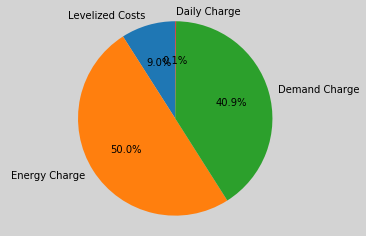

Total roof area of the  building: 1,661 m²
Total roof area used 1,250 m²
Percentage: 75.3%
[[250, 90, 165, 31, 41, 21, 0.4, 0.8499999999999999, 0.4999999999999999, 68727.8, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.616360000007, 'Energy Charge': 34341.80914, 'Demand Charge': 28080.809999999998, 'Daily Charge': 97.5645}, 128923.93535009971, 580100.0, 1250.0]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      115
azi1      155
azi2      205
tilt0      21
tilt1      11
tilt2      31
gcr0     0.65
gcr1     0.35
gcr2      0.4
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 104s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68725.5


ERROR:ga_logger:total demand cost: 28096.260000000002


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,974 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,726 per year


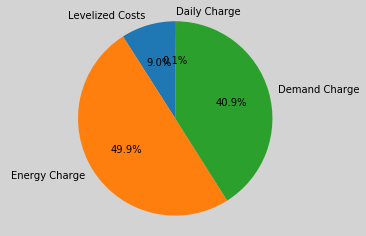

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
[[115, 155, 205, 21, 11, 31, 0.6499999999999999, 0.35, 0.4, 68725.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.652300000002, 'Energy Charge': 34324.023199999996, 'Demand Charge': 28096.260000000002, 'Daily Charge': 97.5645}, 129217.47609861234, 580974.0, 1562.5]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0       95
azi1      110
azi2      175
tilt0       6
tilt1      56
tilt2      26
gcr0     0.25
gcr1     0.35
gcr2      0.6
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68738.1


ERROR:ga_logger:total demand cost: 28100.18


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,356 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,738 per year


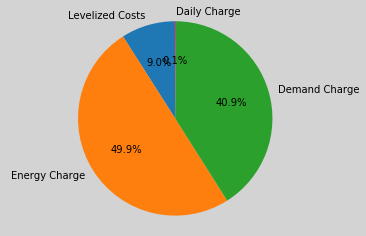

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
[[95, 110, 175, 6, 56, 26, 0.25, 0.35, 0.5999999999999999, 68738.1, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.652290000005, 'Energy Charge': 34332.70321, 'Demand Charge': 28100.18, 'Daily Charge': 97.5645}, 129074.12923295249, 580356.0, 1041.67]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      145
azi1      140
azi2      180
tilt0      11
tilt1      21
tilt2      31
gcr0     0.35
gcr1      0.5
gcr2      0.3
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 316.954, 308.046]


ERROR:ga_logger:Cost: 68728.9


ERROR:ga_logger:total demand cost: 28087.899999999998


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,650 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,729 per year


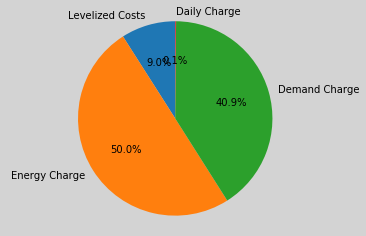

Total roof area of the  building: 1,661 m²
Total roof area used 1,661 m²
Percentage: 100.0%
[[145, 140, 180, 11, 21, 31, 0.35, 0.4999999999999999, 0.3, 68728.9, 625.0, 0.0, 316.954, 308.046, 1, 'blue', {'Levelized Costs': 6207.649550000006, 'Energy Charge': 34335.78594999999, 'Demand Charge': 28087.899999999998, 'Daily Charge': 97.5645}, 129023.26668613032, 580650.0, 1660.73]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      260
azi1      150
azi2      110
tilt0       6
tilt1      21
tilt2      11
gcr0      0.8
gcr1      0.4
gcr2     0.55
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68778.1


ERROR:ga_logger:total demand cost: 28077.95


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 580,965 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,778 per year


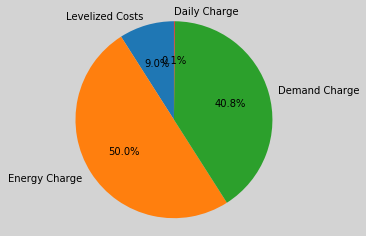

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
[[260, 150, 110, 6, 21, 11, 0.7999999999999998, 0.4, 0.5499999999999999, 68778.1, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.67397, 'Energy Charge': 34394.911530000005, 'Demand Charge': 28077.95, 'Daily Charge': 97.5645}, 128047.44907187318, 580965.0, 1562.5]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      135
azi1      125
azi2      180
tilt0      31
tilt1      56
tilt2      36
gcr0     0.45
gcr1      0.3
gcr2      0.6
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 68808.2


ERROR:ga_logger:total demand cost: 28132.79


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,369 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,808 per year


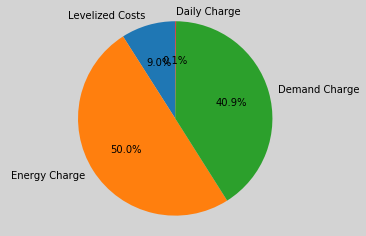

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
[[135, 125, 180, 31, 56, 36, 0.45, 0.3, 0.5999999999999999, 68808.2, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.696599999996, 'Energy Charge': 34370.1489, 'Demand Charge': 28132.79, 'Daily Charge': 97.5645}, 128456.12772779996, 581369.0, 1041.67]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      170
azi1      190
azi2      235
tilt0      31
tilt1       6
tilt2       6
gcr0      0.6
gcr1     0.85
gcr2      0.4
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 6.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68784.0


ERROR:ga_logger:total demand cost: 28116.97


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,601 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,784 per year


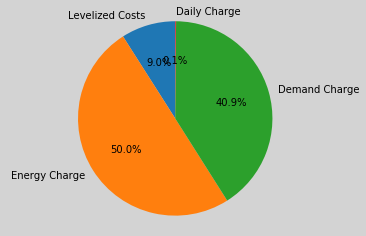

Total roof area of the  building: 1,661 m²
Total roof area used 1,042 m²
Percentage: 62.7%
[[170, 190, 235, 31, 6, 6, 0.5999999999999999, 0.8499999999999999, 0.4, 68784.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.629240000002, 'Energy Charge': 34361.83626, 'Demand Charge': 28116.97, 'Daily Charge': 97.5645}, 128593.57836050027, 581601.0, 1041.67]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      180
azi1       90
azi2      155
tilt0      46
tilt1       1
tilt2      51
gcr0      0.4
gcr1     0.25
gcr2     0.45
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68793.3


ERROR:ga_logger:total demand cost: 28145.349999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 588,159 kWh
At a cost of $ 0.0584 /kWh
Total Cost of the system: $ 68,793 per year


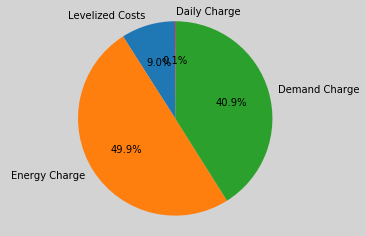

Total roof area of the  building: 1,661 m²
Total roof area used 1,562 m²
Percentage: 94.1%
[[180, 90, 155, 46, 1, 51, 0.4, 0.25, 0.45, 68793.3, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.703000000005, 'Energy Charge': 34342.6825, 'Demand Charge': 28145.349999999995, 'Daily Charge': 97.5645}, 128909.37521710029, 588159.0, 1562.5]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      260
azi1      155
azi2      245
tilt0      46
tilt1      16
tilt2      31
gcr0      0.3
gcr1     0.55
gcr2      0.7
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 104s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 68897.9


ERROR:ga_logger:total demand cost: 28072.409999999996


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,615 kWh
At a cost of $ 0.0594 /kWh
Total Cost of the system: $ 68,898 per year


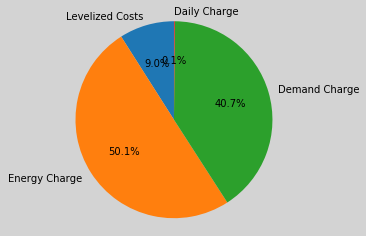

Total roof area of the  building: 1,661 m²
Total roof area used 1,136 m²
Percentage: 68.4%
[[260, 155, 245, 46, 16, 31, 0.3, 0.5499999999999999, 0.7, 68897.9, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.641599999995, 'Energy Charge': 34520.2839, 'Demand Charge': 28072.409999999996, 'Daily Charge': 97.5645}, 125978.9217366998, 581615.0, 1136.36]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      170
azi1      210
azi2      235
tilt0       6
tilt1      31
tilt2      16
gcr0     0.35
gcr1      0.4
gcr2      0.6
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 58s


ERROR:ga_logger:panel relevance: [15.2741, 609.726, 0.0]


ERROR:ga_logger:Cost: 68807.0


ERROR:ga_logger:total demand cost: 28095.75


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,783 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,807 per year


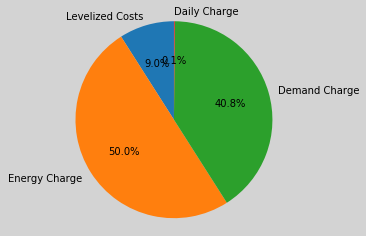

Total roof area of the  building: 1,661 m²
Total roof area used 1,568 m²
Percentage: 94.4%
[[170, 210, 235, 6, 31, 16, 0.35, 0.4, 0.5999999999999999, 68807.0, 625.0001, 15.2741, 609.726, 0.0, 1, 'blue', {'Levelized Costs': 6207.7091999999975, 'Energy Charge': 34405.9763, 'Demand Charge': 28095.75, 'Daily Charge': 97.5645}, 127864.8692652894, 581783.0, 1567.96]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      145
azi1      200
azi2      255
tilt0      31
tilt1      41
tilt2      51
gcr0      0.6
gcr1      0.4
gcr2     0.85
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [34.9346, 590.065, 0.0]


ERROR:ga_logger:Cost: 68812.5


ERROR:ga_logger:total demand cost: 28125.69


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,723 kWh
At a cost of $ 0.0591 /kWh
Total Cost of the system: $ 68,812 per year


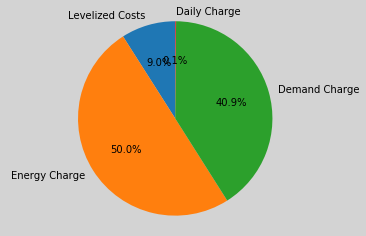

Total roof area of the  building: 1,661 m²
Total roof area used 1,533 m²
Percentage: 92.3%
[[145, 200, 255, 31, 41, 51, 0.5999999999999999, 0.4, 0.8499999999999999, 68812.5, 624.9996000000001, 34.9346, 590.065, 0.0, 1, 'blue', {'Levelized Costs': 6207.682700000001, 'Energy Charge': 34381.5628, 'Demand Charge': 28125.69, 'Daily Charge': 97.5645}, 128267.9467551264, 581723.0, 1533.39]]
The maximum power used is 274 kW
The minimum power used is 19 kW
The average power used is 79 kW
The total Electricity use is 695,621 kWh or 696 MWh
This building is in the **Large General Service** Rate
The maximum demand charge is: $ 29,169.86


ERROR:ga_logger:panel values: azi0      170
azi1      160
azi2      105
tilt0      21
tilt1       6
tilt2      56
gcr0     0.65
gcr1     0.45
gcr2     0.35
Name: 19, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 68831.0


ERROR:ga_logger:total demand cost: 28089.54


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 581,732 kWh
At a cost of $ 0.0592 /kWh
Total Cost of the system: $ 68,831 per year


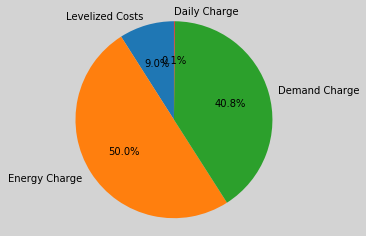

Total roof area of the  building: 1,661 m²
Total roof area used 962 m²
Percentage: 57.9%
[[170, 160, 105, 21, 6, 56, 0.6499999999999999, 0.45, 0.35, 68831.0, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.659809999997, 'Energy Charge': 34436.23569, 'Demand Charge': 28089.54, 'Daily Charge': 97.5645}, 127365.63654676065, 581732.0, 961.538]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)